# **DSCI 100 009 - Group 165 Proposal - Pulsar Stars**

 - By Jasmine Bodis, Nilay Kumar, Muhan Yang, and Zhedong Wang

## *Introduction*

### 1) Background Information

Pulsar is a neutron star that can produce radio waves detectable from Earth. When it spins in high speed, scientists can detect its radio wave patterns. For each rotation, the radio wave pattern emitted is distinctive. Therefore, each sample collected in the dataset refers to the average radio waves produced by multiple rotations.

However, not all detected radio waves are produced by pulsars. Majority of the detections are radio frequency interference (RFI) or noise in space instead of real pulsar signals. Therefore, the dataset contains mostly negative class samples (Class 0), which is the detection of RFI/noise.

### 2) Question of the Project

Using the mean and excess kurtosis of the integrated profile columns from the pulsar dataset, can we use knn-classification method to predict whether a signal is from a pulsar star or radio frequency interference/noise?

### 3) Dataset Description

The dataset we are using is downloaded from UCI Machine Learning Repository. The url is: https://archive.ics.uci.edu/ml/datasets/HTRU2 . The name of the dataset is HTRU2, describing a collected sample of pulsar candidates in the High Time Resolution Universe Survey (South).

HTRU2 consists of 17,898 samples (rows) and 9 columns in total, with 8 columns of continuous variables and 1 column of class variable represented by 0 (negative) and 1 (positive) which can be used for binary classification problems. The negative class includes samples caused by RFI/noise, whereas the positive class refers to real pulsar samples.

Within 8 continuous variables, the first four refers to the mean, standard deviation, excess kurtosis, and the skewness of the integrated pulse profile wave, and the latter four indicates the same four pieces of statistics of the DM-SNR (Dispersion Measure - Signal-to-Noise Ratio) curve created during the signal.

## *Preliminary Exploratory Data Analysis*

In [2]:
library(tidyverse)
library(readxl)
library(DBI)
library(dbplyr)
library(RPostgres)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ rec

In [3]:
pulsar <- read_csv("https://raw.githubusercontent.com/splashhhhhh/dsci100-grp165/main/HTRU_2.csv", col_names = FALSE)
colnames(pulsar) <- c("mean_ip", "sd_ip", "kurt_ip", "skew_ip", "mean_dmsnr", "sd_dmsnr", "kurt_dmsnr", "skew_dmsnr", "class")
pulsar

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,sd_ip,kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurt_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [4]:
pulsar <- pulsar |>
    mutate(class = as_factor(class))
pulsar |>
  pull(class) |>
  levels()

num_obs <- nrow(pulsar)
pulsar |>
    group_by(class) |>
    summarize(count = n(),
             percentage = n() / num_obs * 100)

[1] "0" "1"

class,count,percentage
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


In [5]:
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

training_scaled <- pulsar_training |>
    group_by(class)|>
    slice(1:1000)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



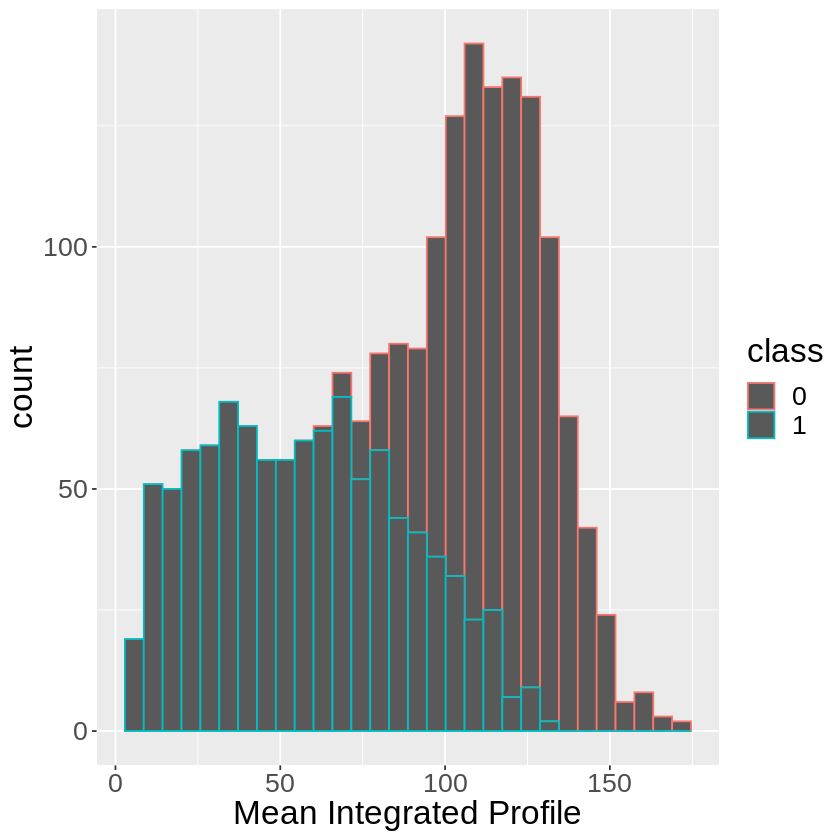

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



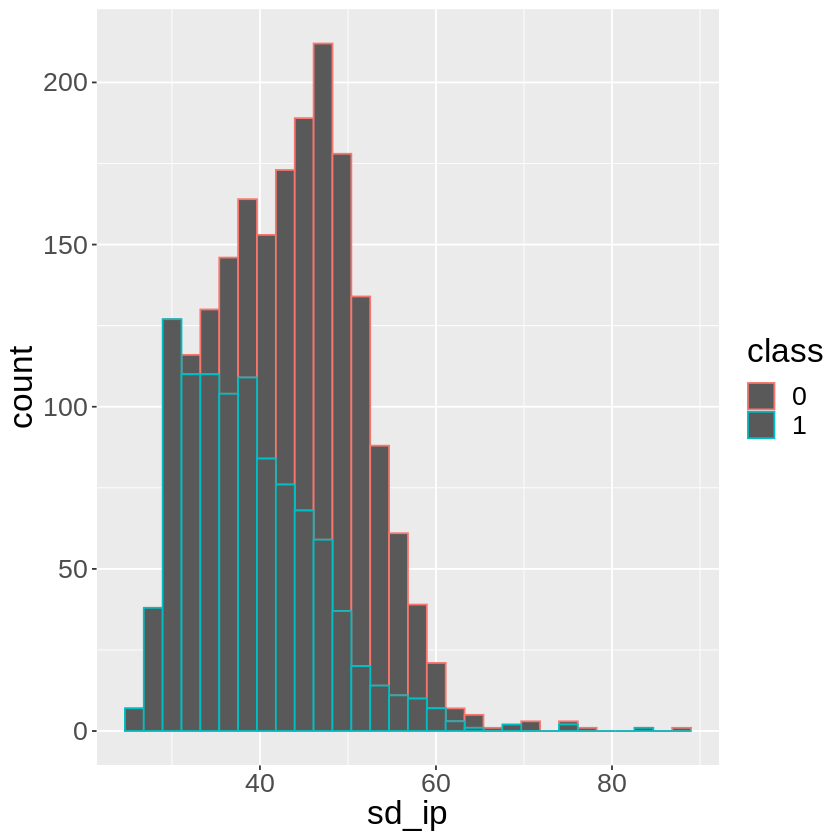

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



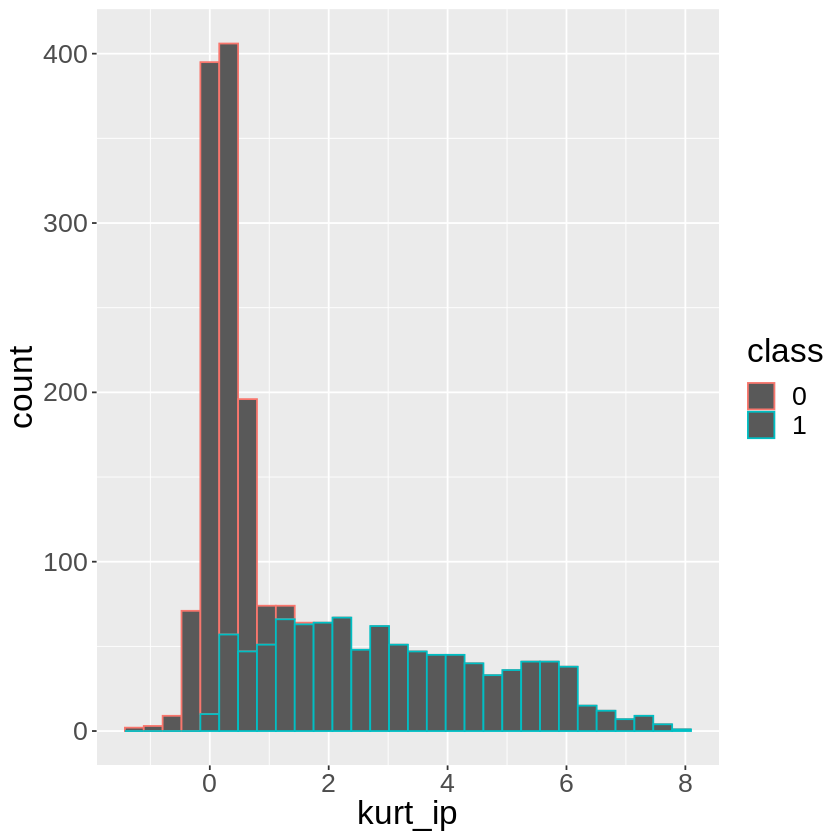

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



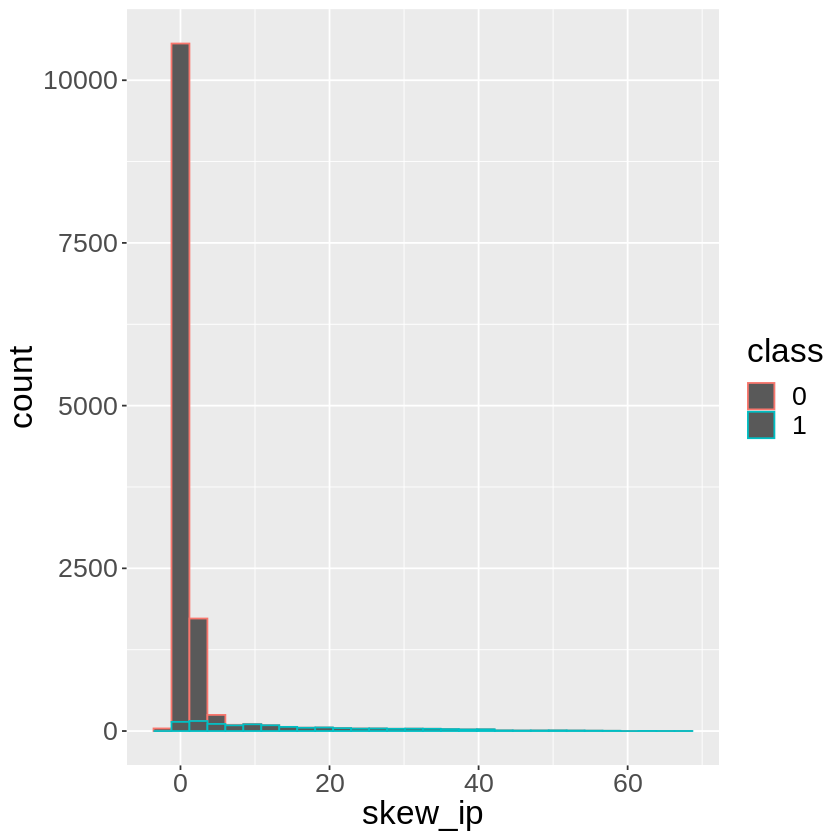

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



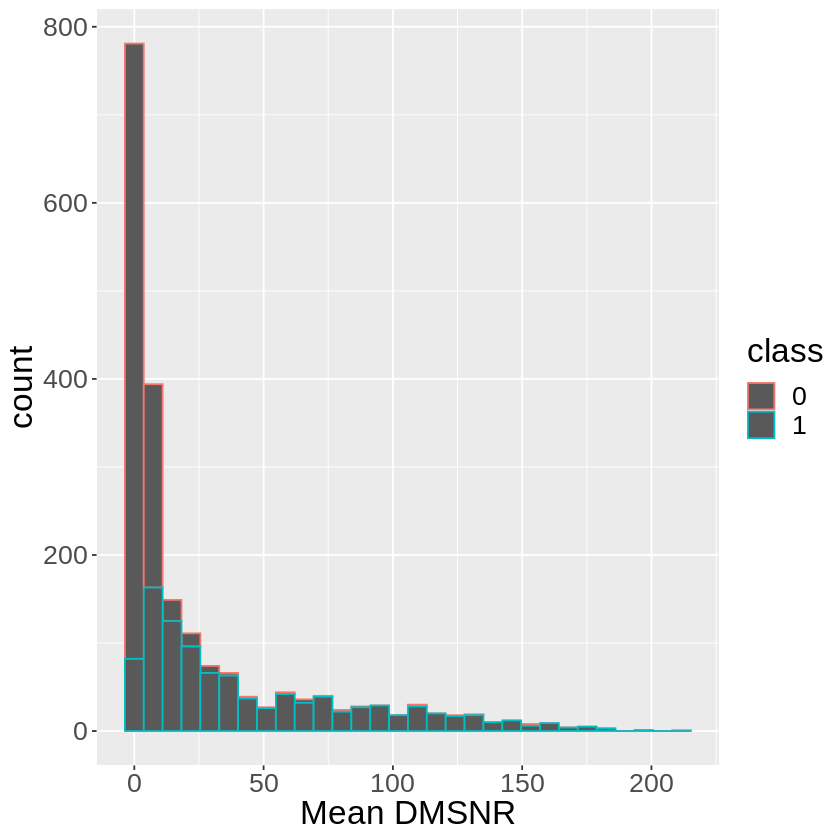

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



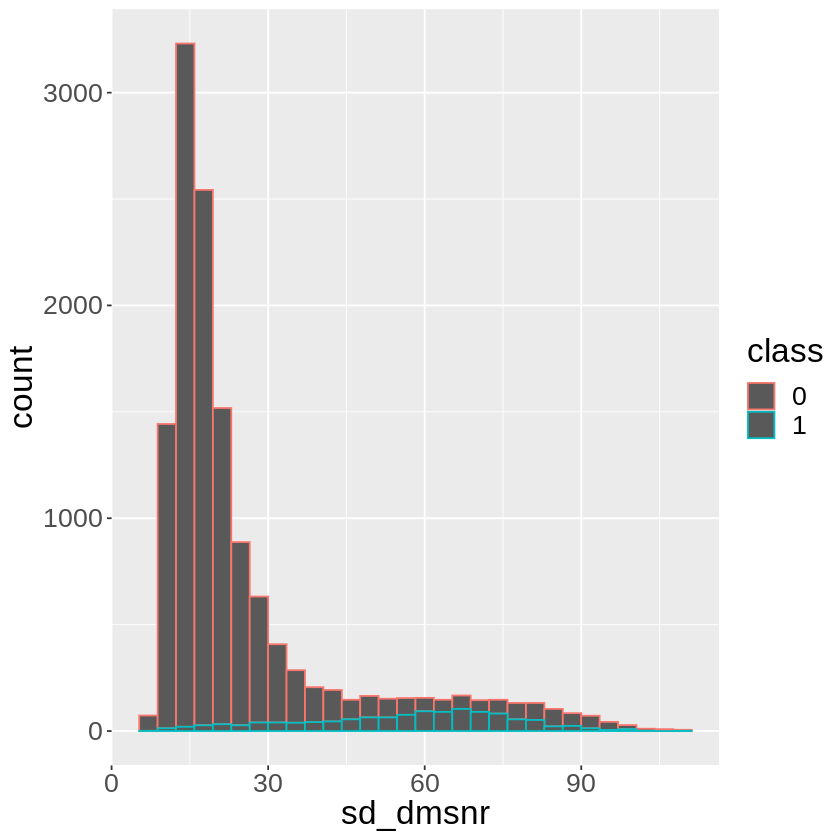

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



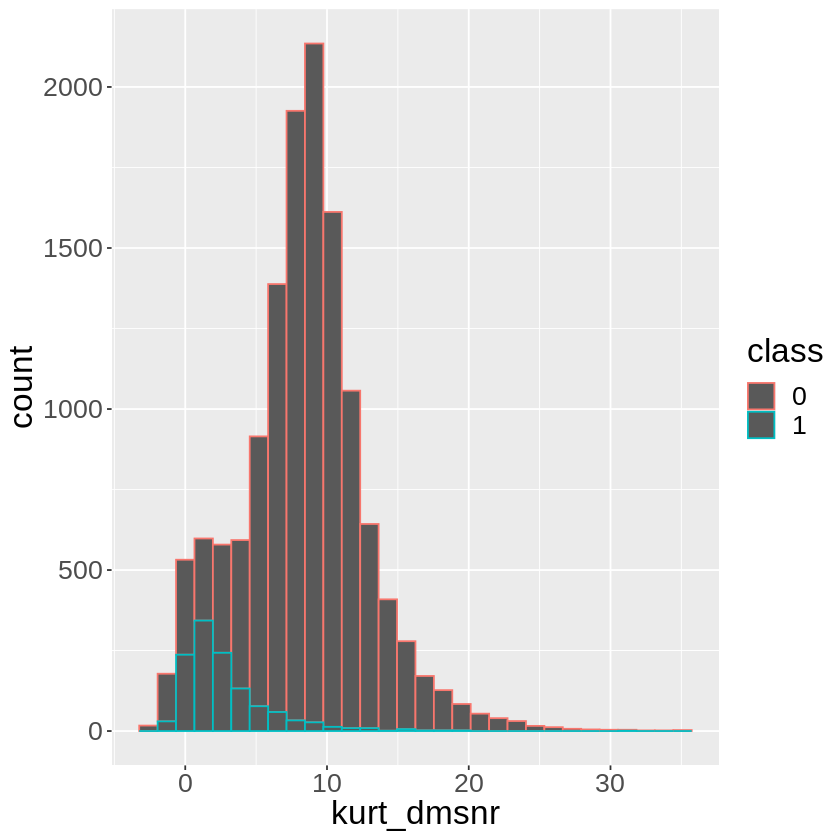

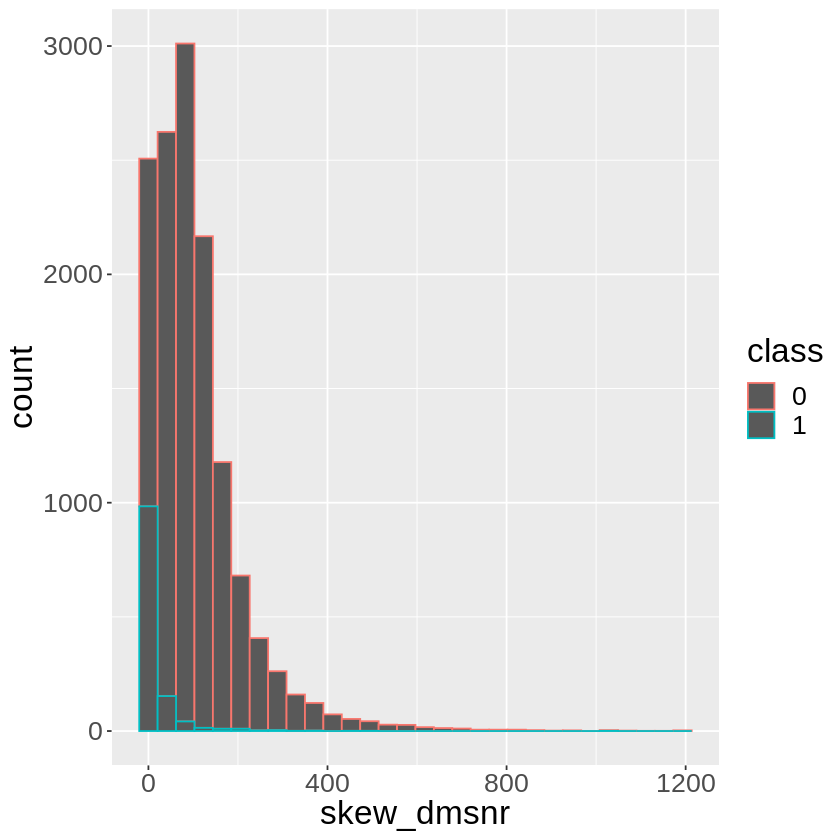

In [6]:
mean_ip_plot <- training_scaled |>
    ggplot(aes(x = mean_ip)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "Mean Integrated Profile") +
    theme(text = element_text(size = 20))              
mean_ip_plot


sd_ip_plot <- training_scaled |>
    ggplot(aes(x = sd_ip)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "sd_ip") +
    theme(text = element_text(size = 20))              
sd_ip_plot


kurt_ip_plot <- training_scaled |>
    ggplot(aes(x = kurt_ip)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "kurt_ip") +
    theme(text = element_text(size = 20))              
kurt_ip_plot

skew_ip_plot <- pulsar_training |>
    ggplot(aes(x = skew_ip)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "skew_ip") +
    theme(text = element_text(size = 20))              
skew_ip_plot

mean_dmsnr_plot <- training_scaled |>
    ggplot(aes(x = mean_dmsnr)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "Mean DMSNR") +
    theme(text = element_text(size = 20))              
mean_dmsnr_plot

sd_dmsnr_plot <- pulsar_training |>
    ggplot(aes(x = sd_dmsnr)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "sd_dmsnr") +
    theme(text = element_text(size = 20))              
sd_dmsnr_plot

kurt_dmsnr <- pulsar_training |>
    ggplot(aes(x = kurt_dmsnr)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "kurt_dmsnr") +
    theme(text = element_text(size = 20))              
kurt_dmsnr

skew_dmsnr <- pulsar_training |>
    ggplot(aes(x = skew_dmsnr)) +
    geom_histogram(aes(colour = class)) + 
    labs(x = "skew_dmsnr") +
    theme(text = element_text(size = 20))              
skew_dmsnr

Since mean_ip and kurt_ip have the most obvious difference between the range of Class 0 compared to that of Class 1, we are going to use mean and excess kurtosis of the integrated profile columns from pulsar training data as our predictor variables.

In [7]:
avg_mean_kurt <- pulsar_training |>
    select(mean_ip, kurt_ip) |>
    map_df(mean)
avg_mean_kurt

mean_ip,kurt_ip
<dbl>,<dbl>
111.1065,0.4758666


The mean of integrated profile mean is 111.0601 and the mean of integrated profile excess kurtosis is 0.4772199.

In [8]:
sum(is.na(pulsar_training))

[1] 0

Since the sum function is equal to 0, we have no rows with missing data.

## *Methods*

### 1) Data analysis and predictors variables choosing

We split the dataset into training and testing with a ratio of 3:1 and scale the training set by selecting 1000 rows, as a huge difference in sample numbers occurs between class 0 and class 1. Therefore, taking 1000 samples from the dataset increases the accuracy of our plot when comparing the frequency between two classes.

For predictors variables, we plan to use the mean and the excess kurtosis of the integrated profile, because from visualizing 8 variables by histograms, the mean_ip and kurt_ip have the smallest overlap between two classes. For example, for mean_ip, the highest frequency of class 1 occurs between 0-100, while the highest frequency of class 0 happens between 50-150. For kurt_ip, class 0 data mainly locates around 0, but class 1 data scatters between 0-6.

By selecting two with the most obvious range differences between class 0 and 1, we could use them as predictors to develop a classification model, using to predict whether a new signal belongs to the radio wave caused by RFI and noise or real pulsar stars. Later in our project, we will create a k-nearest neighbours model using two predictors selected from above, tune it via 5-fold cross-validation, and evaluate its accuracy using our testing datasets.

### 2) A possible way of visualization

One way of visualizing our results is we use cross-validation to calculate an accuracy for each value of K in a reasonable range and plot the estimated accuracy versus different K values using line graph. In this way, we can visualize to decide the best K with the highest accuracy from the plot.

## *Expected Outcomes and Significance*

### 1) What we expect to find

Through visualizing the pulsar data set, we expect to differentiate whether signals are from actual pulsar stars or simply RFI noise by using the K-nearest neighbour classification. By using the training dataset, we can train the model to better predict the class samples.

### 2) Impact of the findings

According to Debesai et al. (2020), pulsar stars are valuable in science, because they release highly regular and periodic signals. Identifying a pulsar star and finding deviated signals from its normal period can help to detect gravity waves, dark matter, and other cosmic phenomena (Debesai et al., 2020)

### 3) Future Questions

Future scope for research can strive to improve the accuracy of the model, since classification methods like KNN classification can be challenging when the dataset is imbalance, that is, the data from one class is significantly more than that of the other class. 

Shi (2020) suggested three ways to improve the performance of KNN model in imbalanced dataset: random oversampling, random undersampling, or ensemble oversampling to the training data. Further investigation can focus on determining which data sampling algorithms fit the best for the classification problem of pulsar stars and RFI noise.

## *References*

Debesai, S., Gutierrez, C., & Ugur Koyluoglu, N. (2020). Application of machine learning methods to identify and categorize radio pulsar signal candidates. 11.


Shi, Z. (2020). Improving k-Nearest Neighbors Algorithm for Imbalanced Data Classification. *IOP Conference Series: Materials Science and Engineering*, 719(1), 012072. https://doi.org/10.1088/1757-899X/719/1/012072
